#### **Imports & Setup**

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from PIL import Image
import pandas as pd
import os
import glob
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt


### **Dataset Definition**



In [3]:
class SignLanguage3DDataset(Dataset):
    """
        SignLanguage3DDataset
        
        A custom PyTorch Dataset for loading sign language image sequences as 3D data.
        It reads from a root directory of images and a CSV file that maps image filenames to class labels.
        
        Attributes:
        -----------
        - root_dir (str): Root folder containing images, organized in a flat structure (All_in_one).
        - csv_path (str): CSV file path containing mappings between images and label names (gesture_labels.csv).
        - num_frames (int): Number of frames per video clip (default = 16).
        - image_size (tuple): Target size to resize each image to (default = (112, 112)).
        - classes (list): Sorted list of unique class labels.
        - data (list): A list of tuples [(image_path_list, label_name), ...].
        
        Initialization:
        ---------------
        - Loads the CSV and builds a mapping from image filename to label.
        - Scans the root directory recursively for .jpg and .png files.
        - Keeps only images that are listed in the CSV and stores their paths with corresponding labels.
        - Applies standard image transformations (resize, normalize, convert to tensor).
        
        Methods:
        --------
        __len__:
            Returns the number of data samples.
        
        __getitem__(idx):
            - Loads the image(s) for a given index.
            - Pads or samples to ensure exactly `num_frames` frames.
            - Extracts the center frame of the clip to return.
            - Converts the label string to a numeric class index.
            - Returns a tuple: (center_frame [C, H, W], label_index [int]).
        
        load_frames(image_paths):
            - Applies image transformations.
            - If fewer than `num_frames`, repeats the last frame.
            - If more than `num_frames`, randomly samples `num_frames` frames.
            - Returns a 4D tensor of shape [C, D, H, W], where:
                - C = channels (3)
                - D = depth (number of frames)
                - H/W = height and width
    """
    def __init__(self, root_dir,csv_path, num_frames=16, image_size=(112, 112)):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.image_size = image_size
        self.classes = sorted(os.listdir(root_dir))
        self.data = []

        # Load CSV and build a filename -> label name map
        df = pd.read_csv(csv_path)
        self.filename_to_label = {}

        for _, row in df.iterrows():
            left_name = os.path.basename(row['stereo left'])
            right_name = os.path.basename(row['stereo right'])
            label = row['label name']
            self.filename_to_label[left_name] = label
            self.filename_to_label[right_name] = label

        # Get all unique class names
        self.classes = sorted(set(self.filename_to_label.values()))

        # Collect image paths and assign labels from CSV
        image_files = glob.glob(os.path.join(root_dir, '**', '*.jpg'), recursive=True) + \
                      glob.glob(os.path.join(root_dir, '**', '*.png'), recursive=True)

        for img_path in image_files:
            img_name = os.path.basename(img_path)
            if img_name in self.filename_to_label:
                label = self.filename_to_label[img_name]
                self.data.append(([img_path], label))

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
    def __len__(self):
        return len(self.data)
    
    def load_frames(self, image_paths):
        # Load and process each image
        frames = [self.transform(Image.open(p).convert("RGB")) for p in image_paths]
        
        if len(frames) < self.num_frames:
            # Repeat last frame to match length
            frames += [frames[-1]] * (self.num_frames - len(frames))
        elif len(frames) > self.num_frames:
            # Randomly sample frames
            indices = sorted(random.sample(range(len(frames)), self.num_frames))
            frames = [frames[i] for i in indices]
        
        return torch.stack(frames, dim=1)  # Shape: [C, D, H, W]
    
    def __getitem__(self, idx):
        frame_paths, label = self.data[idx]
        clip = self.load_frames(frame_paths)  # [C, D, H, W]
    
        center_frame = clip[:, self.num_frames // 2, :, :]  # extract center frame → [C, H, W]
    
        label_idx = self.classes.index(label)
        return center_frame, label_idx

#### **Load & Initialize Dataset**

In [4]:
# 0. Load dataset
root_dir = "All_in_one"
csv_path = "gesture_labels.csv"

# 1. Create the full dataset
dataset = SignLanguage3DDataset(root_dir, csv_path)


### **Data Splitting & Loading**
Split dataset into train/validation/test subsets and create corresponding DataLoaders.


In [22]:
# 2. Shuffle and split indices
total_size = len(dataset)

indices = list(range(total_size))
random.shuffle(indices)

train_split = int(0.7 * total_size)
val_split = int(0.85 * total_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# 3. Create subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 5. Load ResNet18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)  # -> because our dataset is single frame. for sequences use the below model
# model = r3d_18(weights=R3D_18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, len(dataset.classes)) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 6. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

### **Model Training & Loss Visualization**

Epoch 1, Train Loss: 278.0578, Val Loss: 0.0689
Saved best model at epoch 1 with val loss: 0.0689
Epoch 2, Train Loss: 36.7456, Val Loss: 0.0627
Saved best model at epoch 2 with val loss: 0.0627
Epoch 3, Train Loss: 22.9071, Val Loss: 0.0301
Saved best model at epoch 3 with val loss: 0.0301
Epoch 4, Train Loss: 19.0471, Val Loss: 0.0263
Saved best model at epoch 4 with val loss: 0.0263
Epoch 5, Train Loss: 13.5741, Val Loss: 0.0774
Epoch 6, Train Loss: 18.2561, Val Loss: 0.0402
Epoch 7, Train Loss: 11.3685, Val Loss: 0.0144
Saved best model at epoch 7 with val loss: 0.0144
Epoch 8, Train Loss: 9.9407, Val Loss: 0.0241
Epoch 9, Train Loss: 13.3958, Val Loss: 0.0219
Epoch 10, Train Loss: 9.3404, Val Loss: 0.0211


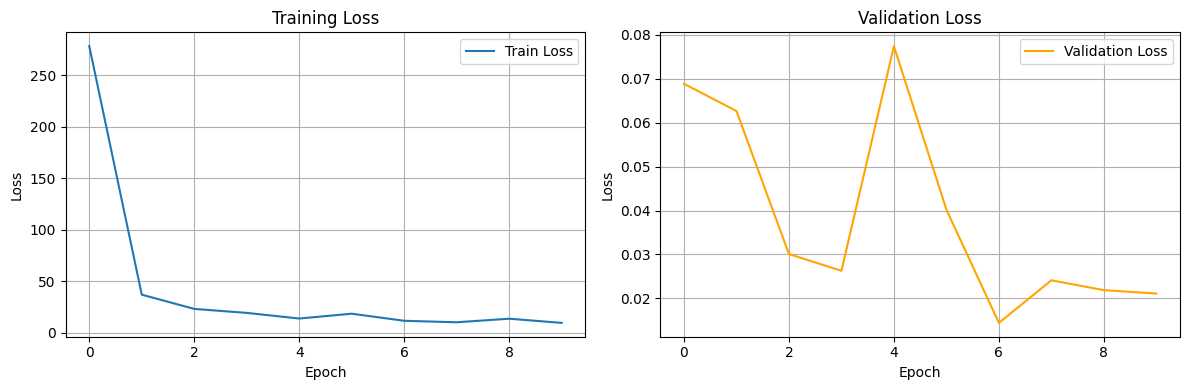

In [37]:
# 7. Training loop
for epoch in range(10):
    model.train()
    total_loss = 0

    for clips, labels in train_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for clips, labels in val_loader:
            clips = clips.to(device)
            labels = labels.to(device)

            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(total_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Training Loss
axs[0].plot(train_losses, label='Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].legend()
axs[0].grid(True)

# Validation Loss (in orange)
axs[1].plot(val_losses, label='Validation Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### **Test Model & Evaluate Performance**
Load the best model, run inference on test data, and compute final loss and accuracy.

In [8]:
# 8. Inference Stage
state_dict = torch.load("best_model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.0040, Test Accuracy: 99.84%


#### **Single Image Prediction**

In [15]:
# 9. guess the gesture
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

image_path = "genova-A_02867_right.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)
input_tensor = input_tensor.to(device)
model.eval()

# Predict
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = dataset.classes[predicted.item()]

print("Predicted gesture:", predicted_class)


Predicted gesture: photo
